In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

2024-11-28 11:01:26.915104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732788086.955213    5015 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732788086.966763    5015 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 11:01:27.020976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Képméret konstansként

image_size = 128

In [3]:
image_data = []
labels = []

train1_dir = './Train1'

for label_folder in tqdm.tqdm(os.listdir(train1_dir)):
    label_path = os.path.join(train1_dir, label_folder)

    if not os.path.isdir(label_path):
        continue

    label = label_folder

    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)

        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        
        image = cv.resize(image, (image_size,image_size))


        image_data.append(image)
        labels.append(label)

image_data = np.array(image_data)
labels = np.array(labels)

image_data = image_data / 255.0

100%|███████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.35it/s]


In [4]:
image_data_train2 = []
labels_train2 = []

train2_dir = './Train2'

for label_folder in tqdm.tqdm(os.listdir(train2_dir)):
    label_path = os.path.join(train2_dir, label_folder)

    if not os.path.isdir(label_path):
        continue

    label = label_folder

    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)

        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        
        image = cv.resize(image, (image_size, image_size))


        image_data_train2.append(image)
        labels_train2.append(label)

image_data_train2 = np.array(image_data_train2)
labels_train2 = np.array(labels_train2)

image_data_train2 = image_data_train2 / 255.0

100%|███████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.57it/s]


In [5]:
# Train1 és Train2 konkatenálása.

image_data  = np.concatenate((image_data, image_data_train2), axis=0)
labels = np.concatenate((labels, labels_train2), axis=0)

In [6]:
# Prediktálandó osztályok száma konstansként.

num_classes = np.count_nonzero(np.unique(labels))


In [7]:
# Címkék átalakítása megfelelő integerré. Majd One-hot encoding a to_categorical függvénnyel.

labels_int = np.array([int(label[6:]) for label in labels])
label_encoder = LabelEncoder()
labels_int_encoded = label_encoder.fit_transform(labels_int)
labels_int_categorical = to_categorical(labels_int_encoded, num_classes=num_classes)


In [8]:
# Define a function to display images in a grid
def display_images_in_grid(image_data, labels, num_images=10, images_per_row=5):
    # Calculate the number of rows needed based on the number of images and images per row
    num_rows = (num_images // images_per_row) + int(num_images % images_per_row != 0)
    
    # Set up a figure with a grid of subplots
    plt.figure(figsize=(10, num_rows * 2))  # Adjust height based on the number of rows
    
    for i in range(num_images):
        # Create subplots with a grid: num_rows x images_per_row
        plt.subplot(num_rows, images_per_row, i + 1)
        
        # Display the image, using a grayscale colormap
        plt.imshow(image_data[i], cmap='gray')
        
        # Show the corresponding label as the title
        plt.title(labels[i])
        plt.axis('off')  # Turn off axes for better visibility
    
    # Show the images
    plt.tight_layout()  # Adjusts layout to prevent overlap
    plt.show()

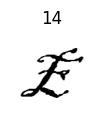

In [9]:
display_images_in_grid(image_data, labels_int_encoded, num_images=1, images_per_row=10)

# Train data felosztása train-test állományra egyenletesen minden címkére


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Split the data into training and test sets, ensuring proportional stratification for each class
for train_index, test_index in splitter.split(image_data, labels):
    X_train, X_test = image_data[train_index], image_data[test_index]
    y_train, y_test = labels_int_categorical[train_index], labels_int_categorical[test_index]

# Data Augmentation


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
datagen = ImageDataGenerator(
    #rotation_range=10,        # 10 fokig elforgathatjuk a képet
    width_shift_range=0.1,    # Képet vízszintesen 10%-kal eltolni
    height_shift_range=0.1,   # Képet függőlegesen 10%-kal eltolni
    shear_range=0.1,          # 10%-os nyírás
    zoom_range=0.3,           # 30%-os nagyítás
    horizontal_flip=False,     # Vízszintes tükrözés nem ajánlott, mert a karakterek irányítottságot hordoznak
    fill_mode='nearest'       # Képek kiegészítése, ha a transzformáció során üres helyek keletkeznek
)

In [14]:
# Reshape X_train to add a channel dimension to fit for datagen.
X_train = X_train.reshape((X_train.shape[0], image_size, image_size, 1))
datagen.fit(X_train)

# Modell kialakítása


In [15]:
from keras.layers import Activation,Conv2D,AveragePooling2D,Flatten,Dropout,Dense, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [16]:
orai_model = Sequential()

orai_model.add(Conv2D(32,(3,3),padding='valid', input_shape=(image_size, image_size, 1)))
orai_model.add(Activation('relu'))
orai_model.add(Conv2D(32,(3,3)))
orai_model.add(Activation('relu'))
orai_model.add(MaxPooling2D(pool_size=(2,2)))
orai_model.add(Dropout(0.25))

orai_model.add(Conv2D(64,(3,3)))
orai_model.add(Activation('relu'))
orai_model.add(Conv2D(64,(3, 3)))
orai_model.add(Activation('relu'))
orai_model.add(MaxPooling2D(pool_size=(2,2)))
orai_model.add(Dropout(0.25))

orai_model.add(Flatten())
orai_model.add(Dense(512))
orai_model.add(Activation('relu'))
orai_model.add(Dropout(0.5))

orai_model.add(Dense(num_classes))
orai_model.add(Activation('softmax'))

/home/levi/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732788135.986953    5015 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5


In [17]:
from tensorflow.keras.layers import BatchNormalization

model128 = Sequential()

# Első konvolúciós blokk
model128.add(Conv2D(32, (5, 5), activation='relu', input_shape=(image_size, image_size, 1)))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Második konvolúciós blokk
model128.add(Conv2D(64, (5, 5), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Harmadik konvolúciós blokk
model128.add(Conv2D(128, (4, 4), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Negyedik konvolúciós blokk
model128.add(Conv2D(256, (3, 3), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))


# Kép lelapítása
model128.add(Flatten())

# Teljesen összekapcsolt réteg
model128.add(Dense(512, activation='relu'))
model128.add(Dropout(0.5))  # Dropout réteg a túlilleszkedés csökkentésére

# Kimeneti réteg
model128.add(Dense(num_classes, activation='softmax'))

In [18]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [19]:
model = model128
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,789,502 (14.46 MB)

 Trainable params: 3,788,542 (14.45 MB)

 Non-trainable params: 960 (3.75 KB)

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
image_size = 128  # Xception requires a minimum input size of 71x71
batch_size = 32
num_classes = 10  # Replace with the number of classes in your dataset

# Load the Xception model, excluding the top fully connected layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(num_classes)(x)
output = Activation('softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

In [20]:
with tf.device('/GPU:0'):
    model.fit(X_train,y_train,batch_size=32,epochs=200,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping])

2024-11-28 11:02:23.237386: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3136159744 exceeds 10% of free system memory.
2024-11-28 11:02:29.741406: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3136159744 exceeds 10% of free system memory.


Epoch 1/200


I0000 00:00:1732788162.092346    5069 service.cc:148] XLA service 0x7f2a10003010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732788162.098251    5069 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-28 11:02:42.369386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732788162.916186    5069 cuda_dnn.cc:529] Loaded cuDNN version 90501
2024-11-28 11:02:45.043740: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,124,124]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,128]{3,2,1,0}, f32[32,1,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"

   2/1496 ━━━━━━━━━━━━━━━━━━━━ 1:26 58ms/step - accuracy: 0.0078 - loss: 8.4642      

I0000 00:00:1732788170.470975    5069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1495/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6036 - loss: 1.6436

2024-11-28 11:03:22.763813: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[14,32,124,124]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,1,128,128]{3,2,1,0}, f32[32,1,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-28 11:03:22.791547: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[14,64,58,58]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,32,62,62]{3,2,1,0}, f32[64,32,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6036 - loss: 1.6432

2024-11-28 11:03:30.183510: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,124,124]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,128]{3,2,1,0}, f32[32,1,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-28 11:03:30.322598: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,58,58]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,62,62]{3,2,1,0}, f32[64,32,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 59s 28ms/step - accuracy: 0.6037 - loss: 1.6428 - val_accuracy: 0.8189 - val_loss: 0.5088
Epoch 2/200
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.8072 - loss: 0.5611 - val_accuracy: 0.8486 - val_loss: 0.3995
Epoch 3/200
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.8384 - loss: 0.4328 - val_accuracy: 0.8744 - val_loss: 0.3115
Epoch 4/200
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8578 - loss: 0.3560 - val_accuracy: 0.8603 - val_loss: 0.3784
Epoch 5/200
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8693 - loss: 0.3233 - val_accuracy: 0.8941 - val_loss: 0.2638
Epoch 6/200
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.8829 - loss: 0.2946 - val_accuracy: 0.8953 - val_loss: 0.2406
Epoch 7/200
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.8960 - loss: 0.2554 - val_accuracy: 0.9041 - val_loss: 0.2415
Epoch 8/200
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.9022 - los

In [21]:
# 3,3 - 93.96
# 4,4 - 93.38
# 5,5 - 94.25
# 5,5 5,5 4,4 3,3 - 94.40
# 5,5 5,5 3,3 3,3 - 93.79
# 5,5 5,5 4,4 3,3 3,3 - 93.17
# 5,5 5,5 5,5 3,3 3,3 - 93.38
# 5,5 5,5 5,5 4,4 3,3 - 93.78
# 5 3 5 3 4 - 93.59
# 6,6 6,6 6,6 6,6 - 93.72
# 7 6 5 4 3 - 93.96
# 5 3 5 3 - 93.72
# model.save_weights("best.weights.h5")

# mind3 93.95
# - 93.31
# rot 94.21
# shear 94.08
# zoom 93.61
# rot,shear 94
# rot, zoom 93.76
# zoom, shear 94.23

# avgpooling 92.76
# dropout 0.3 - 93.74
# shear, zoom = 0.2 - 93.95
# sorted beolvasás - 94.11
# 48as batch 94.17

# Modell visszamérése


In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
pred = model.predict(X_test)
pred_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


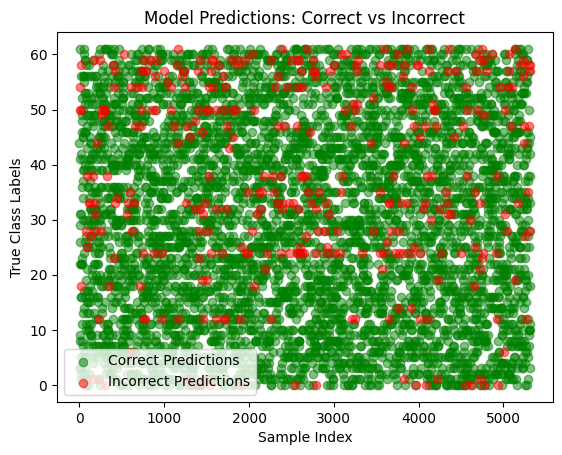

In [24]:
# Find correct and incorrect predictions
correct_indices = np.where(pred_labels == true_labels)[0]
incorrect_indices = np.where(pred_labels != true_labels)[0]

# Create a scatter plot for correct predictions
plt.scatter(correct_indices, true_labels[correct_indices], color='green', label='Correct Predictions', alpha=0.5)

# Create a scatter plot for incorrect predictions
plt.scatter(incorrect_indices, true_labels[incorrect_indices], color='red', label='Incorrect Predictions', alpha=0.5)

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('True Class Labels')
plt.title('Model Predictions: Correct vs Incorrect')
plt.legend()

# Show the plot
plt.show()

# Kideríteni, melyik osztályokban hibázik a modell nagyot, és ott mit tippel.


In [25]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Calculate accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_names = [f'Class {i}' for i in range(len(class_accuracy))]
class_accuracy_dict = dict(zip(class_names, class_accuracy))

# Filter classes with accuracy below x%
low_accuracy_classes = {class_name: accuracy for class_name, accuracy in class_accuracy_dict.items() if accuracy < 0.8}

# Printing the classes with low accuracy
cnt = 0
for class_name, accuracy in low_accuracy_classes.items():
    cnt += 1
    print(f"{class_name}: {accuracy:.2f}")

print("Összesen: " + str(cnt) + " db")

Class 24: 0.62
Class 33: 0.72
Class 47: 0.79
Class 50: 0.72
Class 54: 0.76
Class 57: 0.76
Class 59: 0.78
Összesen: 7 db


In [26]:
# Create a list to store the details of low accuracy predictions
low_accuracy_predictions = []

# Iterate through low accuracy classes and find predictions
for class_name in low_accuracy_classes.keys():
    class_index = int(class_name.split(' ')[-1])  # Extract the class index from the name
    class_indices = np.where(true_labels == class_index)[0]  # Find the indices of true labels that match this class
    
    # Check predictions for these indices
    for idx in class_indices:
        if pred_labels[idx] != true_labels[idx]:  # Only add incorrect predictions
            low_accuracy_predictions.append({
                'Index': idx,
                'True Label': true_labels[idx] + 1, # Azért kell +1, hogy a megfelelő SampleXXX-t lehessen megkapni.
                'Predicted Label': pred_labels[idx] + 1
            })

low_accuracy_df = pd.DataFrame(low_accuracy_predictions)

low_accuracy_df

,Index,True Label,Predicted Label
0,750,25,1
1,884,25,1
2,976,25,51
3,1547,25,51
4,1684,25,1
...,...,...,...
151,2751,60,34
152,3285,60,34
153,4726,60,34
154,4768,60,34


In [ ]:
test_image_data = []
test_labels = []

test_dir = './TestData'


for image_file in sorted(os.listdir(test_dir)):
    image_path = os.path.join(test_dir, image_file)

    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    if image is None:
        continue
        
    image = cv.resize(image, (image_size,image_size))

    test_image_data.append(image)
    test_labels.append(image_file)
    
test_image_data = np.array(test_image_data)

test_image_data = test_image_data / 255.0

test_pred = model.predict(test_image_data)
test_pred_labels = np.argmax(test_pred, axis=1) + 1

data_to_save = np.column_stack((test_pred_labels, test_labels))

np.savetxt("predictions.txt",data_to_save,fmt='%s',delimiter=';')

212/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

# Esetleges modell 128x128-as képfelbontásra.


In [ ]:
uj_model = Sequential()

uj_model.add(Conv2D(32, (4, 4), padding='valid', input_shape=(image_size, image_size, 1)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))

uj_model.add(Conv2D(32, (4, 4)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(MaxPooling2D(pool_size=(2, 2)))

uj_model.add(Conv2D(64, (4, 4)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))

uj_model.add(Conv2D(64, (4, 4)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(MaxPooling2D(pool_size=(2, 2)))

uj_model.add(Conv2D(128, (4, 4)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))

uj_model.add(Conv2D(128, (4, 4)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(MaxPooling2D(pool_size=(2, 2)))

uj_model.add(Flatten())
uj_model.add(Dense(512))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))

uj_model.add(Dense(num_classes))
uj_model.add(Activation('softmax'))